## Parte I: Espectro y reconstrucción usando FFT

Considere la onda definida tal que:

\begin{align}
    g(t) = sgn[\sin(2 \pi f t)]  
\end{align}

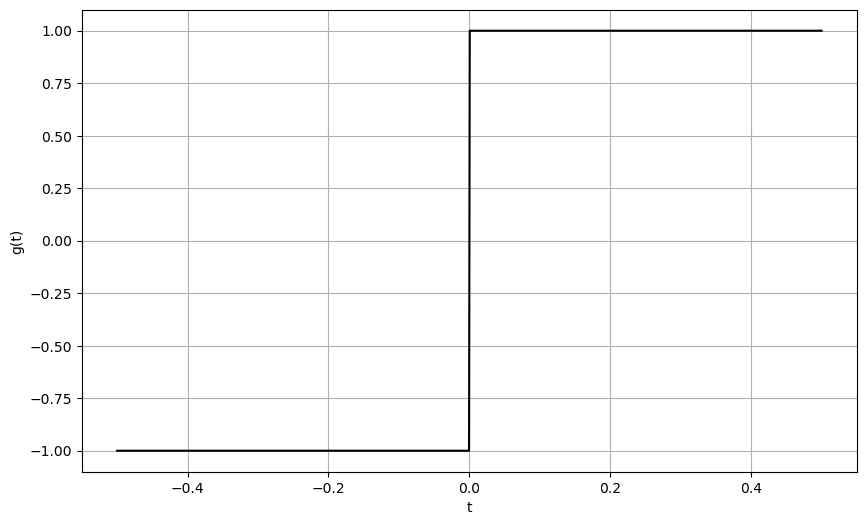

In [5]:
import numpy as np 
import matplotlib.pyplot as plt

def func_signal(f,t): #Se especifica la función que representa la señal en términos de a frecuencia y el tiempo
    return np.sign(np.sin(2.0 * np.pi * f * t)) #Se implementa la función signo

#Se plantea el dominio de la función
#Se utiliza solamente un periodo de la función para establecer el primer gráfico
#(El periodo de la función sin(x) es de 2π, sin embargo el periodo de la señal cuadrada es de 1, por lo que se utiliza encuentra T = [0,1])
t_vals = np.linspace(-0.5, 0.5, 1000) #Se trabaja con este linspace para observar su monotonía 
#Se grafica a función para apreciar su comportamiento
plt.figure(figsize=(10, 6))
plt.plot(t_vals, func_signal(1,t_vals), color = 'black') #Se utiliza una frecuencia de 1Hz
plt.xlabel("t")
plt.ylabel("g(t)")
plt.grid()

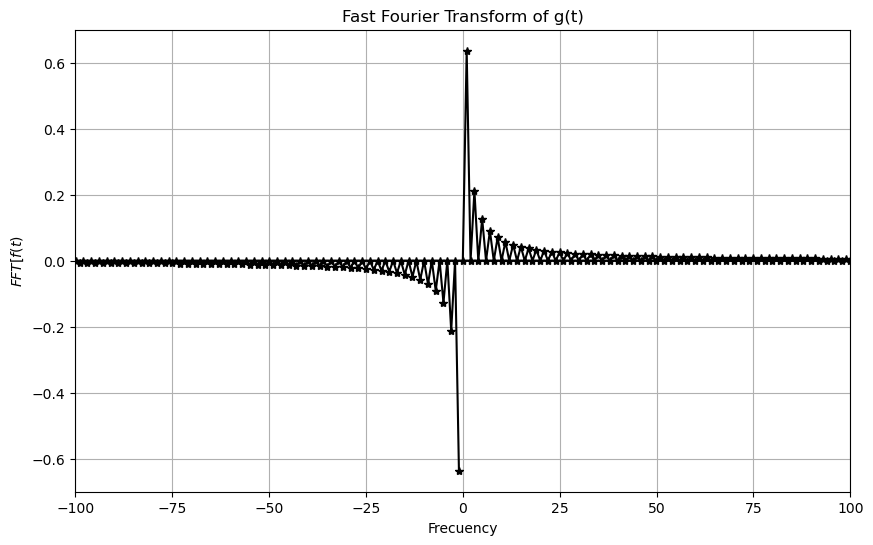

In [6]:
#Se llama a la transformada de Fourier para un solo ciclo de la función
t_vals2 = np.linspace(-0.5, 0.5, 1000) #N = 1000
fourier_t = np.fft.fft(func_signal(1, t_vals2), norm="forward")
#Se retorna la transformada de Fourier en el espacio de frecuencias 
freq = np.fft.fftfreq(len(fourier_t), d=t_vals2[1]-t_vals2[0])
#Se grafica la señal obtenida
plt.figure(figsize=(10, 6))

plt.plot(freq, np.imag(fourier_t), '-*', color = 'black')
#Se limita para poder verla de una forma más apreciativa
plt.xlim(-100,100)
plt.title("Fast Fourier Transform of g(t)")
plt.xlabel(r"Frecuency")
plt.ylabel(r"$FFT[f(t)$")
plt.grid()
plt.show()

*1. Anáisis del espectro*

Este es un espectro simético con respecto a una curva x = y, esto se puede interpretar como una cancelación entre valores positivos y negativos que son los mismos que generan esos picos en las cercanías del cero.

*2. Observaciones con respecto a los modos de oscilación*

Los picos positivos representan los modos de oscliación de las frecuencias impares ($f$, $3f$, $5f$, ...), donde estos mismos son característicos de una onda cuadrada. En el caso de los negativos representan la simetría del espectro.

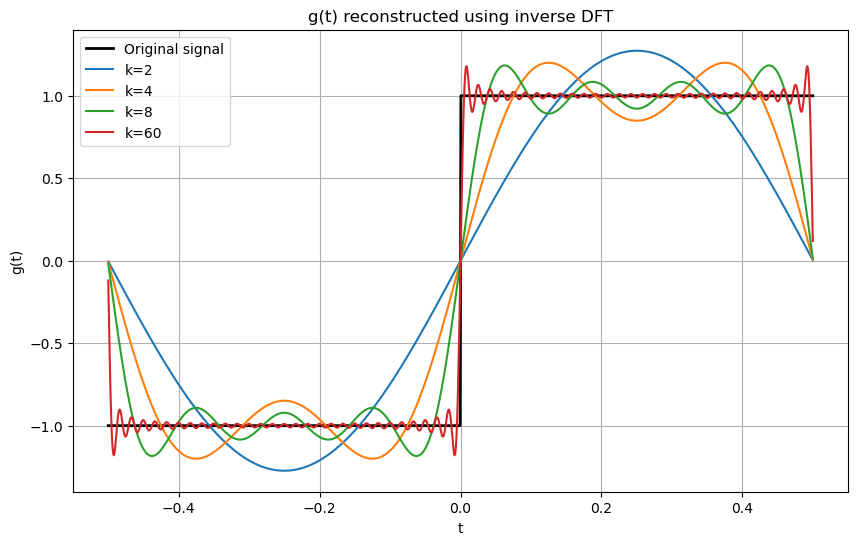

In [8]:
#Definimos una función para la reconstrucción por medio de la forma explícita de la Transformada Inversa de Fourier
def signal_recontruction(coef_k, k, N):
    n = np.arange(N)  #Se generan índices de tiempo
    #Reconstrucción usando la suma de los primeros k términos
    y_n = np.sum(coef_k[:k] * np.exp(1j * 2 * np.pi * np.outer(n, np.arange(k)) / N), axis=1)
    
    return np.real(y_n)  #Parte real de ala reconstrucción

# Calculamos la DFT de la señal
G_f = np.fft.fft(func_signal(1, t_vals2), norm="forward") #Normalización
G_f_half = np.copy(G_f) #Deep copy
G_f_half[freq < 0] = 0  #Se elige trabajar solamente con la parte positiva
G_f_half *= 2 #Se duplica para compensar la simetría de la onda

k_values = [2, 4, 8, 60]

#Graficación de la señal real
plt.figure(figsize=(10, 6))
plt.plot(t_vals2, func_signal(1, t_vals2), label="Original signal", color="black", linewidth=2)
#Graficación de aproximaciones para diferentes valores de k
for k in k_values:
    g_t_reconstructed = signal_recontruction(G_f_half, k, 1000)
    plt.plot(t_vals2, g_t_reconstructed, label=f"k={k}")
plt.xlabel("t")
plt.ylabel("g(t)")
plt.title("g(t) reconstructed using inverse DFT")
plt.legend()
plt.grid()
plt.show()

# Conclusión:

Dentro de valores de $k$ pequeños se aprecian detalles significantes de la señal, sin embargo carece de apego a la realidad de esta. Por ejemplo, para un *k = 2* se aprecia una onda sinusoidal donde se apegan realmente los nodos y poco más, sin embargo conforme $k$ va aumentando su valor la amplitud y comportamiento de la señal se va volviendo más claro, como con *k = 60* que se puede intuir una convergencia tanto en el valor de *t = 0.0* como en la amplitud de la señal que apenas si se distorciona cerca de los nodos de la onda.

## Parte II: Ecuaciones Elípticas

Se resolverá la ecuación de Laplace para un potencial electroestático bidimensional $\phi = \phi(x,y)$

\begin{align}
    \dfrac { \partial \phi ^{2}}{\partial x ^{2}} + \dfrac { \partial \phi ^{2}}{\partial y ^{2}} = 0
\end{align}

Esto se hará para una placa cuadrada de 10cmx10cm

In [ ]:

#Se utilizan las definiciones dadas por el profesor

def jacobi_relaxation(M, V, tolerance):
    # Primero creamos los arreglos 2-dimensionales de la grilla
    # Vamos a necesitar dos según la regla de Jacobi
    # Note que usamos M+1, debido a que debemos contener la condición de frontera
    # phi contiene inicialmente los valores iniciales. Vamos a utilizar ceros.
    phi = np.zeros((M + 1, M + 1), dtype=float)
    
    #Condiciones de frontera
    phi[20:80, 20] = V # Placa izquierda 
    phi[20:80,80] = -1.0*V # Placa derecha

    phiprime = np.zeros((M + 1, M + 1), dtype=float)
    # Iteración de Jacobi
    delta = 1.0
    its = 0
    while delta > tolerance:
        # Calculamos la iteración
        its += 1
        for i in range(M + 1):
            for j in range(M + 1):
                # Condición de frontera
                if i == 0 or i == M or j == 0 or j == M:
                    phiprime[i, j] = phi[i, j]
                # Iteración principal
                else:
                    phiprime[i,j] = 0.25*(phi[i+1,j] + phi[i-1,j] + phi[i, j+1]  + phi[i, j-1])
        # Calculamos la diferencia máxima con respecto a los valores anteriores
        delta = np.max(np.abs(phi - phiprime))
        # Ahora intercambiamos los arreglos para la nueva iteración
        # El nuevo phi es el phiprime
        temp = phi
        phi = phiprime
        # El nuevo phiprime es el phi viejo
        phiprime = temp
        
    return phi, its

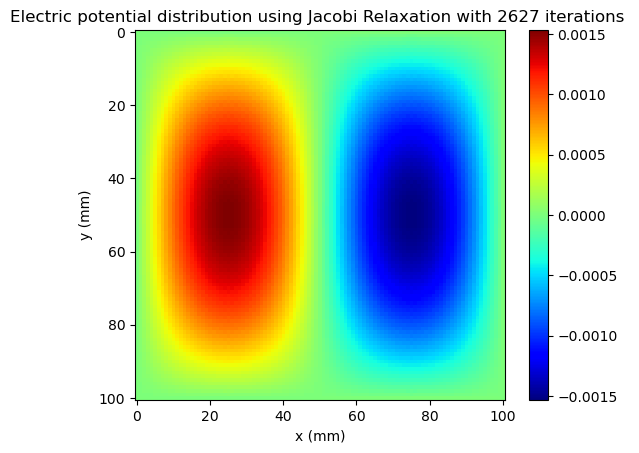

In [ ]:
#Se utilizan los parámetros pedidos en el enunciado
jacobi_vals, iterations = jacobi_relaxation(100, 1, 1e-5)

plt.imshow(jacobi_vals)
plt.colorbar()  
plt.jet()
plt.title(f"Electric potential distribution using Jacobi Relaxation with {iterations} iterations ")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()